# Train Vision Transformer

In [1]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import crunchy_snow.models
import crunchy_snow.dataset

## Prepare dataloader

In [2]:
# get paths to data
train_data_dir = '/mnt/Backups/gbrench/repos/crunchy-snow/data/subsetsv1/train'
train_path_list = glob(f'{train_data_dir}/ASO_50M_SD*.nc')[0:128]

val_data_dir = '/mnt/Backups/gbrench/repos/crunchy-snow/data/subsetsv1/val'
val_path_list = glob(f'{val_data_dir}/ASO_50M_SD*.nc')[0:128]

In [3]:
# define data to be returned by dataloader
selected_channels = ['aso_sd', # ASO lidar snow depth (target dataset)
                     'snowon_vv', # snow on Sentinel-1 VV polarization backscatter
                     'snowon_vh', # snow on Sentinel-1 VH polarization backscatter
                     'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter
                     'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter
                     'blue', # snow on Sentinel-2 blue band
                     'green', # snow on Sentinel-2 green band
                     'red', # snow on Sentinel-2 red band
                     'fcf', # fractional forest cover
                     'elevation', # elevation (COP30 DEM)
                     'aso_gap_map', # gaps in ASO data
                     'rtc_gap_map', # gaps in Sentinel-1 data
                     'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
                     'ndsi', # Normalized Difference Snow Index from Sentinel-2
                     'ndwi' # Normalized Difference Water Index from Sentinel-2
                    ]

# prepare training and validation dataloaders
train_data = crunchy_snow.dataset.Dataset(train_path_list, selected_channels, norm=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_data = crunchy_snow.dataset.Dataset(val_path_list, selected_channels, norm=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=1, shuffle=True)

## Train model

In [4]:
# import model
model = crunchy_snow.models.VisionTransformer(input_channels=12)
model.to('cuda');  # Run on GPU

In [5]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
epochs = 50

train_loss = []
val_loss = []

for epoch in range(epochs):
    print(f'\nStarting epoch {epoch+1}')
    epoch_loss = []
    val_temp_loss = []

    # Loop through training data
    for (aso_sd, snowon_vv, snowon_vh, snowoff_vv, snowoff_vh, blue, green, red, fcf, elevation, aso_gap_map, rtc_gap_map, ndvi, ndsi, ndwi) in train_loader:
        model.train()
        optimizer.zero_grad()
        
        # Concatenate all feature channels
        inputs = torch.cat((snowon_vv, snowon_vh, snowoff_vv, snowoff_vh, blue, green, red, fcf, elevation, ndvi, ndsi, ndwi), dim=1).to('cuda')
        pred_sd = torch.clamp(model(inputs), 0, 1)  # Generate predictions

        # Limit prediction to areas with valid data
        pred_sd = torch.where(aso_gap_map.to('cuda') + rtc_gap_map.to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
        aso_sd = torch.where(aso_gap_map.to('cuda') + rtc_gap_map.to('cuda') == 0, aso_sd.to('cuda'), torch.zeros_like(pred_sd).to('cuda'))

        # Calculate loss
        loss = loss_fn(pred_sd, aso_sd.to('cuda'))
        epoch_loss.append(loss.item())

        loss.backward()  # Propagate the gradients in backward pass
        optimizer.step()

    train_loss.append(np.mean(epoch_loss))
    print(f'Training loss: {np.mean(epoch_loss)}')

    # Run model on validation data
    for (aso_sd, snowon_vv, snowon_vh, snowoff_vv, snowoff_vh, blue, green, red, fcf, elevation, aso_gap_map, rtc_gap_map, ndvi, ndsi, ndwi) in val_loader:
        with torch.no_grad():
            model.eval()
            
            # Concatenate all feature channels
            inputs = torch.cat((snowon_vv, snowon_vh, snowoff_vv, snowoff_vh, blue, green, red, fcf, elevation, ndvi, ndsi, ndwi), dim=1).to('cuda')
            pred_sd = torch.clamp(model(inputs), 0, 1)  # Generate predictions
    
            # Limit prediction to areas with valid data
            pred_sd = torch.where(aso_gap_map.to('cuda') + rtc_gap_map.to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
            aso_sd = torch.where(aso_gap_map.to('cuda') + rtc_gap_map.to('cuda') == 0, aso_sd.to('cuda'), torch.zeros_like(pred_sd).to('cuda'))

            loss = loss_fn(pred_sd, aso_sd.to('cuda'))
            val_temp_loss.append(loss.item())

    val_loss.append(np.mean(val_temp_loss))
    print(f'Validation loss: {np.mean(val_temp_loss)}')
    
    # # save model
    # torch.save(model.state_dict(), f'../../weights/VisionTransformer_v0')

    # # save loss 
    # with open('../../loss/VisionTransformer_v0_val_loss.pkl', 'wb') as f:
    #     pickle.dump(val_loss, f)
        
    # with open('../../loss/VisionTransformer_v0_train_loss.pkl', 'wb') as f:
    #     pickle.dump(train_loss, f)


Starting epoch 1
Training loss: 0.02724943865905516
Validation loss: 0.007694507200540102

Starting epoch 2
Training loss: 0.003677857923321426
Validation loss: 0.007455564023075567

Starting epoch 3
Training loss: 0.003537318087182939
Validation loss: 0.007347671437855752

Starting epoch 4
Training loss: 0.003501650964608416
Validation loss: 0.007348415474552894

Starting epoch 5
Training loss: 0.0034751367347780615
Validation loss: 0.0073024909252126236

Starting epoch 6
Training loss: 0.0034528705291450024
Validation loss: 0.007307196649890102

Starting epoch 7
Training loss: 0.0034384758619125932
Validation loss: 0.0072523649760114495

Starting epoch 8
Training loss: 0.0034067645901814103
Validation loss: 0.007252218038047431

Starting epoch 9
Training loss: 0.003406722971703857



KeyboardInterrupt



## Examine results

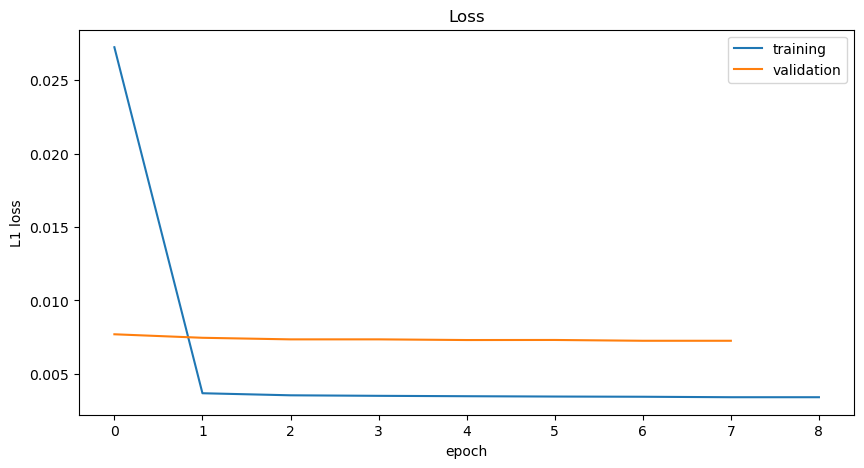

In [6]:
#plot loss over all epochs
f, ax = plt.subplots(figsize=(10,5))
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('L1 loss')
ax.set_title('Loss')
ax.legend()
# plt.savefig('../../figs/VisionTransformer_v0_loss1.png', dpi=300)

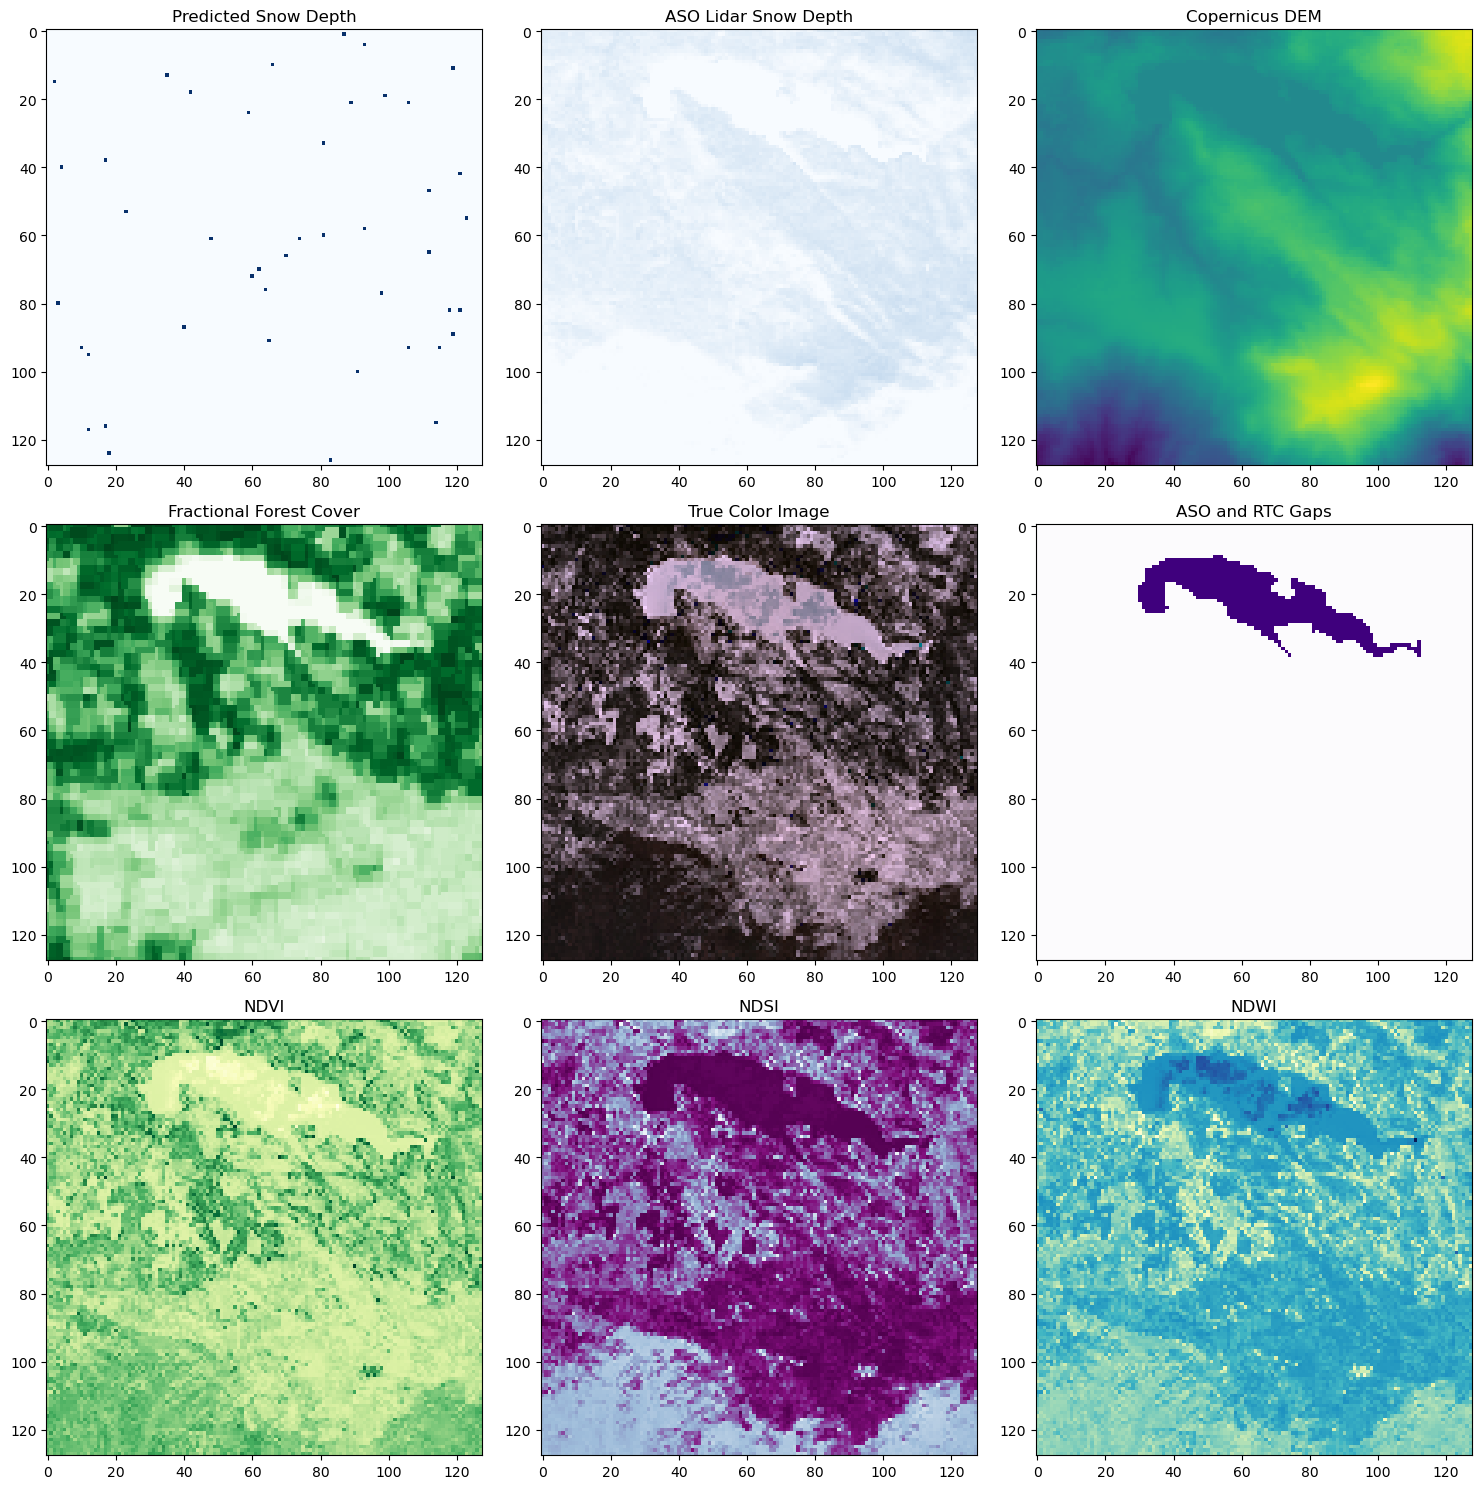

In [7]:
# Visualize model outputs
num_images = 1

for i, (aso_sd, snowon_vv, snowon_vh, snowoff_vv, snowoff_vh, blue, green, red, fcf, elevation, aso_gap_map, rtc_gap_map, ndvi, ndsi, ndwi) in enumerate(val_loader):
    if i < num_images:
        with torch.no_grad():
            # Concatenate all feature channels
            inputs = torch.cat((snowon_vv, snowon_vh, snowoff_vv, snowoff_vh, blue, green, red, fcf, elevation, ndvi, ndsi, ndwi), dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')
            
            f, ax = plt.subplots(3, 3, figsize=(15, 15))
            ax[0, 0].imshow(pred_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
            ax[0, 0].set_title('Predicted Snow Depth')
            ax[0, 1].imshow(aso_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
            ax[0, 1].set_title('ASO Lidar Snow Depth')
            ax[0, 2].imshow(elevation.squeeze(), cmap='viridis', interpolation='none')
            ax[0, 2].set_title('Copernicus DEM')
            ax[1, 0].imshow(fcf.squeeze(), cmap='Greens', interpolation='none')
            ax[1, 0].set_title('Fractional Forest Cover')
            norm_max = np.max([green.max(), red.max(), blue.max()])  # There are better ways to do this
            ax[1, 1].imshow(torch.cat((red.squeeze()[:, :, None] / norm_max, green.squeeze()[:, :, None] / norm_max, blue.squeeze()[:, :, None] / norm_max), 2).squeeze(), interpolation='none')
            ax[1, 1].set_title('True Color Image')
            ax[1, 2].imshow(aso_gap_map.squeeze() + rtc_gap_map.squeeze(), cmap='Purples', interpolation='none')
            ax[1, 2].set_title('ASO and RTC Gaps')
            ax[2, 0].imshow(ndvi.squeeze(), cmap='YlGn', interpolation='none')
            ax[2, 0].set_title('NDVI')
            ax[2, 1].imshow(ndsi.squeeze(), cmap='BuPu', interpolation='none')
            ax[2, 1].set_title('NDSI')
            ax[2, 2].imshow(ndwi.squeeze(), cmap='YlGnBu', interpolation='none')
            ax[2, 2].set_title('NDWI')

            plt.tight_layout()
            # plt.savefig('../../figs/VisionTransformer_v0_pred_raw.png', dpi=300)
    else:
        break